In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-16 07:18:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-16 07:18:48 (84.4 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



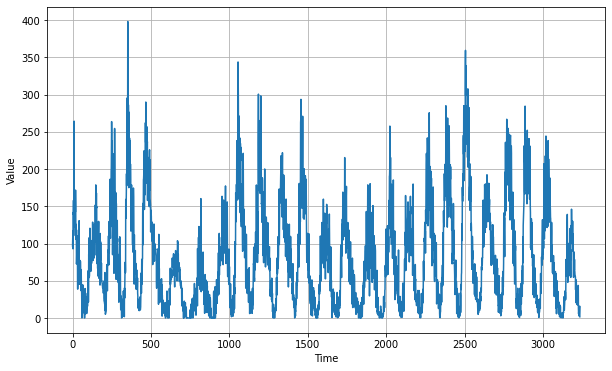

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

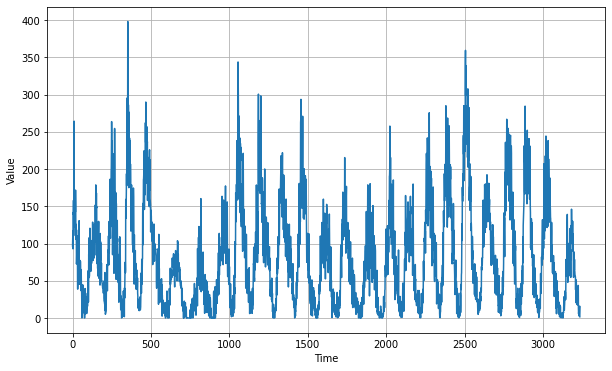

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 1s 52ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 1s 53ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 1s 54ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 1s 55ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 1s 54ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 1s 55ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 1s 54ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 1s 56ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 1s 54ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

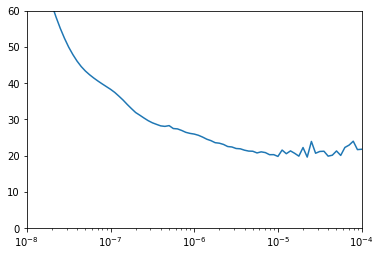

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 1s 32ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 1s 32ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 1s 32ms/step - loss: 22.0760 - mae: 22.5697
Epoch 4/500
30/30 [==============================] - 1s 32ms/step - loss: 20.4696 - mae: 20.9626
Epoch 5/500
30/30 [==============================] - 1s 32ms/step - loss: 19.7647 - mae: 20.2571
Epoch 6/500
30/30 [==============================] - 1s 31ms/step - loss: 19.3094 - mae: 19.8015
Epoch 7/500
30/30 [==============================] - 1s 32ms/step - loss: 18.7216 - mae: 19.2137
Epoch 8/500
30/30 [==============================] - 1s 32ms/step - loss: 18.1125 - mae: 18.6042
Epoch 9/500
30/30 [==============================] - 1s 31ms/step - loss: 18.0770 - mae: 18.5686
Epoch 10/500
30/30 [==============================] - 1s 33ms/step - loss: 17.9281 - mae: 18.4195
Epoch 11/500
30/30 [=========

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

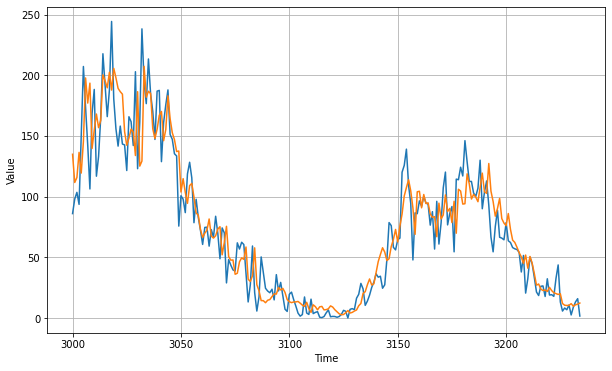

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.289468

<Figure size 432x288 with 0 Axes>

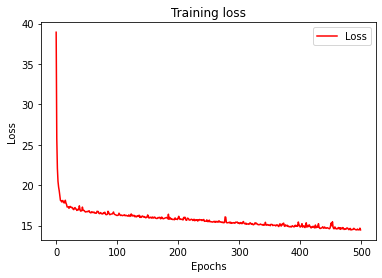

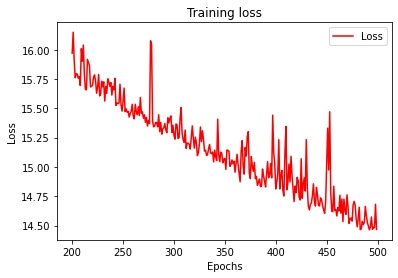

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[134.8708    111.63088   115.73401   136.42297   119.38307   145.41444
 197.77254   177.05554   193.49194   139.63142   154.79216   168.0196
 156.78998   162.80804   200.35541   195.43045   189.62294   202.46663
 187.77676   205.64404   197.95105   189.19438   186.46797   184.38058
 153.51349   142.32446   148.19188   155.58804   153.28041   133.83427
 186.41559   125.12366   129.30249   207.33809   181.87602   186.7927
 184.95331   155.81586   147.9008    155.47026   166.97064   170.15204
 146.06656   155.24785   183.05174   164.18015   152.64362   146.9317
 137.1227    137.55406   103.79041   114.78039   103.47027    94.43743
 109.077     110.88416    99.62048    86.4784     84.678635   72.961845
  66.34515    69.85247    72.416405   81.55514    67.45205    65.83902
  67.727745   73.24786    75.20312    52.036137   62.150394   75.52816
  50.5508     47.63382    47.80699    36.014545   36.84332    46.28247
  49.515022   48.258675   58.469696   31.920544   30.113274   34.80324
  57.777